In [8]:
import sys, os
from pathlib import Path

project_root = "/Users/merlijnbroekers/Desktop/Drone_Interception"   # ← adjust if needed
if project_root not in sys.path: sys.path.insert(0, project_root)

print("PYTHONPATH ok — current cwd:", os.getcwd())
print("src/ exists?  ", os.path.exists(Path(project_root) / "src"))

from pathlib import Path
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import re

PYTHONPATH ok — current cwd: /Users/merlijnbroekers/Desktop/Drone_Interception/scripts/analysis
src/ exists?   True


No event files under /Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/action_history_testing_motor/logs/history_0
Saved to /Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/action_history_testing_motor/logs/eval_mean_reward_compare_square.png


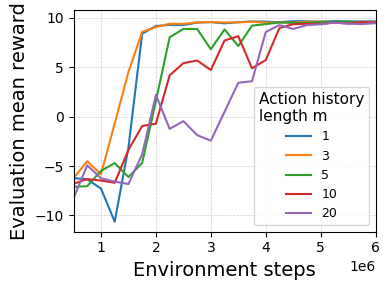

In [17]:
import re
from pathlib import Path
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

BASE = Path("/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/action_history_testing_motor/logs")
TAG = "eval/mean_reward"   # or "eval/mean_ep_length"

def get_history_num(top_dir: Path) -> int:
    """Return numeric history length from dir name, e.g. history_10 -> 10.
    If it fails, return a big number so it goes to the end.
    """
    m = re.search(r"(\d+)$", top_dir.name)
    if m:
        return int(m.group(1))
    return 999999

def smooth_series(values, smoothing=0.1):
    if not values:
        return values
    smoothed = [values[0]]
    last = values[0]
    for v in values[1:]:
        last = smoothing * last + (1.0 - smoothing) * v
        smoothed.append(last)
    return smoothed

# 1) collect all (m, run_dir, event_file)
run_entries = []
for top_run in BASE.iterdir():
    if not top_run.is_dir():
        continue
    event_files = list(top_run.rglob("events.*"))
    if not event_files:
        print(f"No event files under {top_run}")
        continue
    m = get_history_num(top_run)
    run_entries.append((m, top_run, event_files[0]))

# 2) sort by m
run_entries.sort(key=lambda x: x[0])

plt.figure(figsize=(4, 3))
plotted_any = False

for m, top_run, event_file in run_entries:
    try:
        ea = event_accumulator.EventAccumulator(
            str(event_file.parent),
            size_guidance={event_accumulator.SCALARS: 0},
        )
        ea.Reload()
    except Exception as e:
        print(f"Skipping {event_file} → {e}")
        continue

    scalar_tags = ea.Tags().get("scalars", [])
    if TAG not in scalar_tags:
        print(f"{top_run} (via {event_file}) has no tag '{TAG}', it has: {scalar_tags}")
        continue

    events = ea.Scalars(TAG)
    steps  = [e.step for e in events]
    values = [e.value for e in events]

    if not steps:
        print(f"{top_run} → tag '{TAG}' has no data")
        continue

    values_smooth = smooth_series(values, smoothing=0.1)

    # legend entry: just the number
    plt.plot(steps, values_smooth, label=str(m))
    plotted_any = True

plt.xlabel("Environment steps", fontsize=14)
plt.ylabel("Evaluation mean reward", fontsize=14)

plt.xlim(500_000, 6_000_000)
plt.ylim(auto=True)

plt.legend(title="Action history\nlength m", loc="best",
           fontsize=9, title_fontsize=11)

plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()

out_path = BASE / "eval_mean_reward_compare_square.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Saved to {out_path}")

plt.show()
